### 1 - Import test data

In [2]:
import pandas as pd
import pandas_ta as ta
from tqdm import tqdm
import os
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

tqdm.pandas()

def read_csv_to_dataframe(file_path):
    df = pd.read_csv(file_path, sep='\t')
    df['fecha']=pd.to_datetime(df['fecha'])
    df['fecha2']=pd.to_datetime(df['fecha2'])    
    df['hour'] = df['fecha2'].dt.hour
    df=df.query("hour>=10 and hour<=16").sort_values(by=["fecha2"],ascending=True)
    df=df.rename(columns={"open": "Open", "close": "Close", "high": "High", "low": "Low", "fecha2":"date", "volume":"Volume"})
    return df

#def read_data_folder(folder_path="./data"):
#    dataframes = []
#    file_names = []
#    for file_name in tqdm(os.listdir(folder_path)):
#        if file_name.endswith('.csv'):
#            file_path = os.path.join(folder_path, file_name)
#            df = read_csv_to_dataframe(file_path)
#            dataframes.append(df)
#            file_names.append(file_name)
#    return dataframes, file_names

def read_data_folder(file_path):
    dataframes = []
    df = read_csv_to_dataframe(file_path)
    tickers = df['companyName'].drop_duplicates().tolist()
    for ticker in tickers:     
        print(ticker)
        df2 = df.query("companyName==@ticker")
        df2['Gmt time'] = df2["date"]
        df2.set_index("Gmt time", inplace=True)
        print(len(df2))
        dataframes.append(df2)            
    return dataframes

def total_signal(df, current_candle):
    current_pos = df.index.get_loc(current_candle)
    
    # Buy condition
    c1 = df['High'].iloc[current_pos] > df['High'].iloc[current_pos-1]
    c2 = df['High'].iloc[current_pos-1] > df['Low'].iloc[current_pos]
    c3 = df['Low'].iloc[current_pos] > df['High'].iloc[current_pos-2]
    c4 = df['High'].iloc[current_pos-2] > df['Low'].iloc[current_pos-1]
    c5 = df['Low'].iloc[current_pos-1] > df['High'].iloc[current_pos-3]
    c6 = df['High'].iloc[current_pos-3] > df['Low'].iloc[current_pos-2]
    c7 = df['Low'].iloc[current_pos-2] > df['Low'].iloc[current_pos-3]

    if c1 and c2 and c3 and c4 and c5 and c6 and c7:
        return 2

    # Symmetrical conditions for short (sell condition)
    c1 = df['Low'].iloc[current_pos] < df['Low'].iloc[current_pos-1]
    c2 = df['Low'].iloc[current_pos-1] < df['High'].iloc[current_pos]
    c3 = df['High'].iloc[current_pos] < df['Low'].iloc[current_pos-2]
    c4 = df['Low'].iloc[current_pos-2] < df['High'].iloc[current_pos-1]
    c5 = df['High'].iloc[current_pos-1] < df['Low'].iloc[current_pos-3]
    c6 = df['Low'].iloc[current_pos-3] < df['High'].iloc[current_pos-2]
    c7 = df['High'].iloc[current_pos-2] < df['High'].iloc[current_pos-3]

    if c1 and c2 and c3 and c4 and c5 and c6 and c7:
        return 1

    return 0

def add_total_signal(df):
    df['TotalSignal'] = df.progress_apply(lambda row: total_signal(df, row.name), axis=1)
    return df

def add_pointpos_column(df, signal_column):
    """
    Adds a 'pointpos' column to the DataFrame to indicate the position of support and resistance points.
    
    Parameters:
    df (DataFrame): DataFrame containing the stock data with the specified SR column, 'Low', and 'High' columns.
    sr_column (str): The name of the column to consider for the SR (support/resistance) points.
    
    Returns:
    DataFrame: The original DataFrame with an additional 'pointpos' column.
    """
    def pointpos(row):
        if row[signal_column] == 2:
            return row['Low'] - 1e-4
        elif row[signal_column] == 1:
            return row['High'] + 1e-4
        else:
            return np.nan

    df['pointpos'] = df.apply(lambda row: pointpos(row), axis=1)
    return df

def plot_candlestick_with_signals(df, start_index, num_rows):
    """
    Plots a candlestick chart with signal points.
    
    Parameters:
    df (DataFrame): DataFrame containing the stock data with 'Open', 'High', 'Low', 'Close', and 'pointpos' columns.
    start_index (int): The starting index for the subset of data to plot.
    num_rows (int): The number of rows of data to plot.
    
    Returns:
    None
    """
    df_subset = df[start_index:start_index + num_rows]
    
    fig = make_subplots(rows=1, cols=1)
    
    fig.add_trace(go.Candlestick(x=df_subset.index,
                                 open=df_subset['Open'],
                                 high=df_subset['High'],
                                 low=df_subset['Low'],
                                 close=df_subset['Close'],
                                 name='Candlesticks'),
                  row=1, col=1)
    
    fig.add_trace(go.Scatter(x=df_subset.index, y=df_subset['pointpos'], mode="markers",
                             marker=dict(size=10, color="MediumPurple", symbol='circle'),
                             name="Entry Points"),
                  row=1, col=1)
    
    fig.update_layout(
        width=1200, 
        height=800, 
        plot_bgcolor='black',
        paper_bgcolor='black',
        font=dict(color='white'),
        xaxis=dict(showgrid=False, zeroline=False),
        yaxis=dict(showgrid=False, zeroline=False),
        showlegend=True,
        legend=dict(
            x=0.01,
            y=0.99,
            traceorder="normal",
            font=dict(
                family="sans-serif",
                size=12,
                color="white"
            ),
            bgcolor="black",
            bordercolor="gray",
            borderwidth=2
        )
    )
    
    fig.show()

In [4]:
#folder_path = r"D:\CARLOS\TRADING\data_forex"
#dataframes, file_names = read_data_folder(folder_path)

#for i, df in enumerate(dataframes):
#    print("working on dataframe ", i, "...")
#    df = add_total_signal(df)
#    df = add_pointpos_column(df, "TotalSignal")
#    dataframes[i] = df  # Update the dataframe in the list
file_path = r'D:\traderxpro\data\df_h.txt'
dataframes = read_data_folder(file_path)

for i, df in enumerate(dataframes):     
    print("working on dataframe ", i, "...")
    df = add_total_signal(df)
    df = add_pointpos_column(df, "TotalSignal")
    dataframes[i] = df  # Update the dataframe in the list

SPY
3444
working on dataframe  0 ...


100%|██████████| 3444/3444 [00:00<00:00, 5527.93it/s]


In [6]:
sum([frame["TotalSignal"].value_counts() for frame in dataframes], start=0)

TotalSignal
0    3299
2      88
1      57
Name: count, dtype: int64

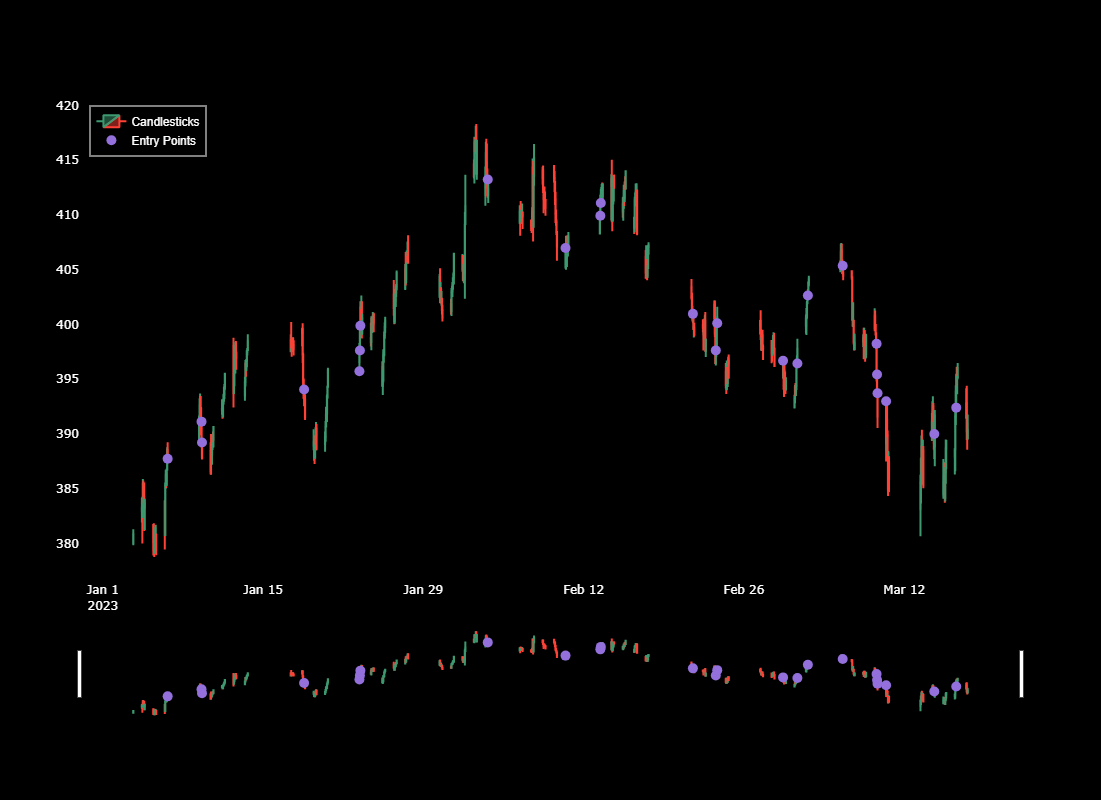

In [54]:
plot_candlestick_with_signals(dataframes[0], start_index=300, num_rows=355)

In [44]:
from backtesting import Strategy
from backtesting import Backtest

def SIGNAL():
    return df.TotalSignal

class MyStrat(Strategy):
    mysize = 0.1  # Trade size
    slperc = 0.01
    tpperc = 0.02

    def init(self):
        super().init()
        self.signal1 = self.I(SIGNAL)  # Assuming SIGNAL is a function that returns signals

    def next(self):
        super().next()
         
        if self.signal1 == 2 and not self.position:
            # Open a new long position with calculated SL and TP
            current_close = self.data.Close[-1]
            sl = current_close - self.slperc * current_close  # SL at 4% below the close price
            tp = current_close + self.tpperc * current_close  # TP at 2% above the close price
            self.buy(size=self.mysize, sl=sl, tp=tp)

        elif self.signal1 == 1 and not self.position:
            # Open a new short position, setting SL based on a strategy-specific requirement
            current_close = self.data.Close[-1]
            sl = current_close + self.slperc * current_close  # SL at 4% below the close price
            tp = current_close - self.tpperc * current_close  # TP at 2% above the close price
            self.sell(size=self.mysize, sl=sl, tp=tp)


In [46]:
bt = Backtest(df, MyStrat, cash=1000, margin=1/50, commission=.0002)
stat = bt.run()
stat

Start                     2022-11-01 10:00:00
End                       2024-10-16 16:00:00
Duration                    715 days 06:00:00
Exposure Time [%]                   31.968641
Equity Final [$]                   716.547056
Equity Peak [$]                   1173.100949
Return [%]                         -28.345294
Buy & Hold Return [%]               50.046116
Return (Ann.) [%]                  -15.694278
Volatility (Ann.) [%]               30.350478
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -44.57021
Avg. Drawdown [%]                   -7.130974
Max. Drawdown Duration      691 days 05:00:00
Avg. Drawdown Duration       87 days 04:00:00
# Trades                                   97
Win Rate [%]                         47.42268
Best Trade [%]                       1.648437
Worst Trade [%]                     -1.656526
Avg. Trade [%]                    

In [48]:
df

,fecha,Open,High,Low,Close,Volume,companyName,date,hour,TotalSignal,pointpos
2022-11-01 10:00:00,2022-11-01 09:00:00,390.3600,390.45,387.740,388.0407,8055718,SPY,2022-11-01 10:00:00,10,0,NaN
2022-11-01 11:00:00,2022-11-01 10:00:00,388.1200,388.40,383.580,384.0100,14288966,SPY,2022-11-01 11:00:00,11,0,NaN
2022-11-01 12:00:00,2022-11-01 11:00:00,384.0100,384.82,383.290,384.5400,7807397,SPY,2022-11-01 12:00:00,12,0,NaN
2022-11-01 13:00:00,2022-11-01 12:00:00,384.5299,386.02,383.970,384.7300,6861108,SPY,2022-11-01 13:00:00,13,0,NaN
2022-11-01 14:00:00,2022-11-01 13:00:00,384.7300,385.45,384.270,385.0900,4554927,SPY,2022-11-01 14:00:00,14,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2024-10-16 12:00:00,2024-10-16 11:00:00,580.1200,580.90,579.780,580.2400,3564060,SPY,2024-10-16 12:00:00,12,0,NaN
2024-10-16 13:00:00,2024-10-16 12:00:00,580.2350,581.40,580.200,581.3900,1871979,SPY,2024-10-16 13:00:00,13,0,NaN
2024-10-16 14:00:00,2024-10-16 13:00:00,581.4000,581.69,580.935,581.6350,2290796,SPY,2024-10-16 14:00:00,14,0,NaN
2024-10-16 15:00:00,2024-10-16 14:00:00,581.6300,582.83,581.480,582.4000,3234392,SPY,2024-10-16 15:00:00,15,2,581.4799


In [50]:
bt.plot()

C:\Users\carlo\anaconda3\Lib\site-packages\backtesting\_plotting.py:250: UserWarning:

DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'

C:\Users\carlo\anaconda3\Lib\site-packages\backtesting\_plotting.py:250: UserWarning:

DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'

C:\Users\carlo\anaconda3\Lib\site-packages\backtesting\_plotting.py:659: UserWarning:

found multiple competing values for 'toolbar.active_drag' property; using the latest value

C:\Users\carlo\anaconda3\Lib\site-packages\backtesting\_plotting.py:659: UserWarning:

found multiple competing values for 'toolbar.active_scroll' property; using the latest value



GridPlot(id='p1732', ...)

In [18]:
results = []
heatmaps = []

for df in dataframes:
    bt = Backtest(df, MyStrat, cash=5000, margin=1/5, commission=0.0002)
    stats, heatmap = bt.optimize(slperc=[i/100 for i in range(1, 8)],
                                 tpperc=[i/100 for i in range(1, 8)],
                    maximize='Return [%]', max_tries=3000,
                        random_state=0,
                        return_heatmap=True)
    results.append(stats)
    heatmaps.append(heatmap)

  0%|          | 0/13 [00:00<?, ?it/s]

In [20]:
agg_returns = sum([r["Return [%]"] for r in results])
num_trades = sum([r["# Trades"] for r in results])
max_drawdown = min([r["Max. Drawdown [%]"] for r in results])
avg_drawdown = sum([r["Avg. Drawdown [%]"] for r in results]) / len(results)

win_rate = sum([r["Win Rate [%]"] for r in results]) / len(results)
best_trade = max([r["Best Trade [%]"] for r in results])
worst_trade = min([r["Worst Trade [%]"] for r in results])
avg_trade = sum([r["Avg. Trade [%]"] for r in results]) / len(results)
#max_trade_duration = max([r["Max. Trade Duration"] for r in results])
#avg_trade_duration = sum([r["Avg. Trade Duration"] for r in results]) / len(results)

print(f"Aggregated Returns: {agg_returns:.2f}%")
print(f"Number of Trades: {num_trades}")
print(f"Maximum Drawdown: {max_drawdown:.2f}%")
print(f"Average Drawdown: {avg_drawdown:.2f}%")
print(f"Win Rate: {win_rate:.2f}%")
print(f"Best Trade: {best_trade:.2f}%")
print(f"Worst Trade: {worst_trade:.2f}%")
print(f"Average Trade: {avg_trade:.2f}%")
#print(f"Maximum Trade Duration: {max_trade_duration} days")
#print(f"Average Trade Duration: {avg_trade_duration:.2f} days")


Aggregated Returns: 13.89%
Number of Trades: 38
Maximum Drawdown: -5.75%
Average Drawdown: -0.50%
Win Rate: 60.53%
Best Trade: 6.03%
Worst Trade: -4.63%
Average Trade: 0.72%


In [22]:
equity_curves = [stats['_equity_curve']['Equity'] for stats in results]
max_length = max(len(equity) for equity in equity_curves)

# Pad each equity curve with the first value to match the maximum length
padded_equity_curves = []
for equity in equity_curves:
    first_value = equity.iloc[0]
    padding = [first_value] * (max_length - len(equity))
    padded_equity = padding + equity.tolist()
    padded_equity_curves.append(padded_equity)

equity_df = pd.DataFrame(padded_equity_curves).T

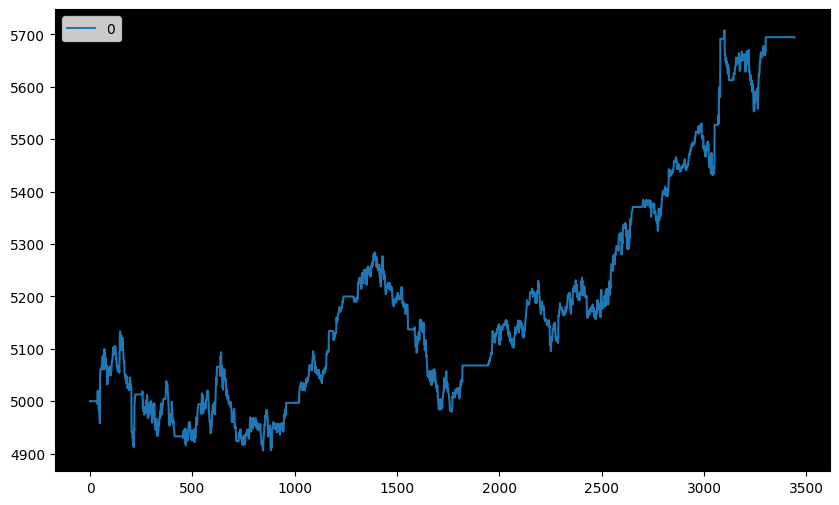

In [24]:
import matplotlib.pyplot as plt

equity_df.plot(kind='line', figsize=(10, 6), legend=True).set_facecolor('black')
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.gca().tick_params(axis='x', colors='black')
plt.gca().tick_params(axis='y', colors='black')
plt.gca().set_facecolor('black')
#plt.legend(file_names)

In [26]:
[r["Return [%]"] for r in results]

[13.88675796240015]

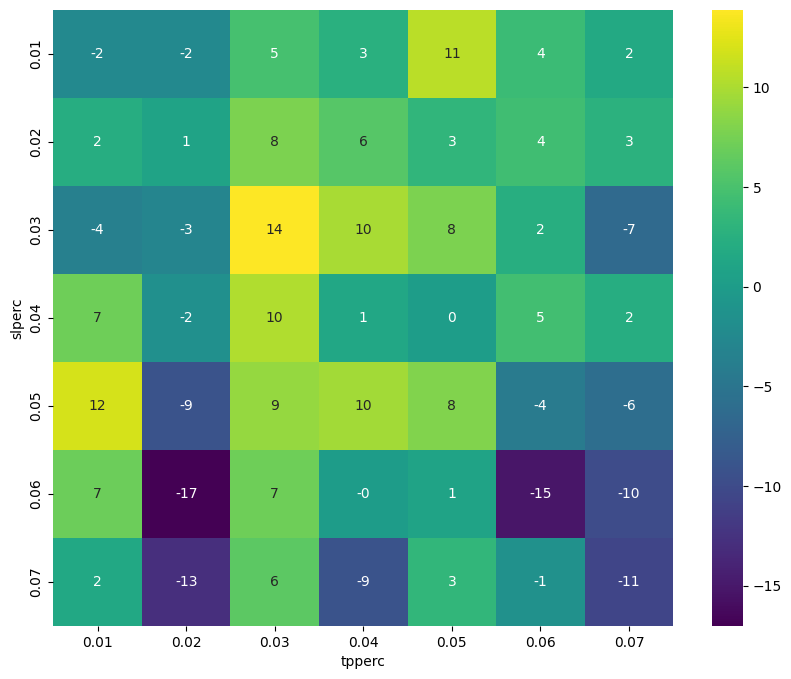

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert multiindex series to dataframe
heatmap_df = heatmaps[0].unstack()
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_df, annot=True, cmap='viridis', fmt='.0f')
plt.show()

In [30]:
results[1]

IndexError: list index out of range

In [42]:
heatmaps[0]

slperc  tpperc
0.01    0.01      -2.461894
        0.02      -2.453758
        0.03       4.725029
        0.04       2.589826
        0.05      10.702121
        0.06       4.015203
        0.07       1.674988
0.02    0.01       2.241972
        0.02       0.911371
        0.03       7.776124
        0.04       5.729171
        0.05       3.151829
        0.06       4.389196
        0.07       2.700309
0.03    0.01      -3.621710
        0.02      -2.903817
        0.03      13.886758
        0.04       9.858215
        0.05       7.833226
        0.06       2.321844
        0.07      -6.510116
0.04    0.01       7.075718
        0.02      -1.618280
        0.03      10.200385
        0.04       1.401010
        0.05       0.061342
        0.06       4.566276
        0.07       2.202729
0.05    0.01      11.954107
        0.02      -9.107230
        0.03       9.058163
        0.04       9.647055
        0.05       7.984120
        0.06      -4.272270
        0.07      -5.939743
0.06 